In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Bagian 1: Setup dan Impor Pustaka
!pip install catboost
!pip install xgboost
!pip install scikit-learn pandas joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00


In [ ]:
import os
import joblib
import pickle
import pandas as pd
import numpy as np

# Pustaka Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Pustaka ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Diperlukan untuk download file di Google Colab
from google.colab import files

print("Setup Pustaka Selesai. (Pustaka visualisasi ditambahkan)")

Setup Pustaka Selesai. (Pustaka visualisasi ditambahkan)


In [ ]:
# Bagian 2: Pemuatan Data, Pemisahan X & y, dan Analisis Distribusi Target

df = pd.read_csv("/content/drive/MyDrive/Final Project 3/Diabetes_and_LifeStyle_Dataset .csv")
df.head()

,Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,52,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


/tmp/ipython-input-2762784386.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y, order=y.value_counts().index, palette="viridis")


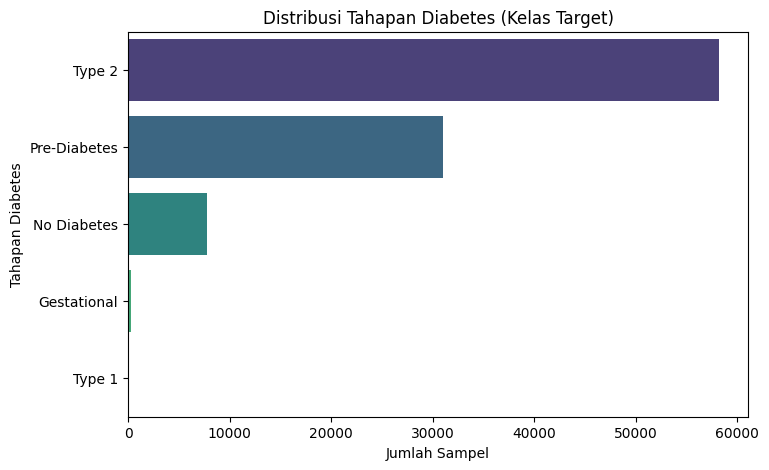


Data Split Selesai. Train=77837, Test=19460


In [ ]:
# ----------------------------------------------------
# 1. DEFINISI FITUR DAN TARGET
# ----------------------------------------------------
TARGET_COLUMN = "diabetes_stage"
COLUMNS_TO_DROP = ['diagnosed_diabetes', 'diabetes_risk_score']

X = df.drop(COLUMNS_TO_DROP + [TARGET_COLUMN], axis=1)
y = df[TARGET_COLUMN]

# Identifikasi Fitur (Diperlukan untuk Pipeline)
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# ----------------------------------------------------
# 2. VISUALISASI DISTRIBUSI TARGET
# ----------------------------------------------------
# Grafik ini menunjukkan apakah data target seimbang (imbalanced)
plt.figure(figsize=(8, 5))
sns.countplot(y=y, order=y.value_counts().index, palette="viridis")
plt.title('Distribusi Tahapan Diabetes (Kelas Target)')
plt.xlabel('Jumlah Sampel')
plt.ylabel('Tahapan Diabetes')
plt.show()

# ----------------------------------------------------
# 3. LABEL ENCODING TARGET DAN SPLIT DATA
# ----------------------------------------------------
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)
global encoders; encoders = {'diabetes_stage': target_encoder} # Simpan encoder

# Split data (80% Train, 20% Test) dengan Stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"\nData Split Selesai. Train={len(X_train)}, Test={len(X_test)}")

In [ ]:
# Bagian 3: Pembangunan Pipeline dan Training Model

# ----------------------------------------------------
# 1. PEMBUATAN PREPROCESSING PIPELINE (ColumnTransformer)
# ----------------------------------------------------
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("Preprocessing Pipeline Selesai Dibuat.")


# ----------------------------------------------------
# 2. PEMBANGUNAN 3 MODEL PIPELINE (CatBoost, RF, XGBoost)
# ----------------------------------------------------

# Model Utama (CatBoost)
cat_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        verbose=0,
        random_state=42,
        auto_class_weights='Balanced'
    ))
])

# Model Perbandingan — Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight='balanced'
    ))
])

# Model Perbandingan — XGBoost
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        objective='multi:softmax',
        num_class=len(target_encoder.classes_),
        eval_metric='mlogloss',
        random_state=42
    ))
])

print("\nMemulai Training Ketiga Model...")
cat_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
print("Training Ketiga Model Selesai.")


Preprocessing Pipeline Selesai Dibuat.

Memulai Training Ketiga Model...
Training Ketiga Model Selesai.


 Evaluasi Model: CatBoost Classifier
Akurasi: 0.9134

Classification Report:
              precision    recall  f1-score   support

 Gestational       0.00      0.00      0.00        53
 No Diabetes       0.85      1.00      0.92      1548
Pre-Diabetes       0.82      1.00      0.90      6203
      Type 1       0.00      0.00      0.00        23
      Type 2       1.00      0.86      0.92     11633

    accuracy                           0.91     19460
   macro avg       0.53      0.57      0.55     19460
weighted avg       0.93      0.91      0.91     19460



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 600x500 with 0 Axes>

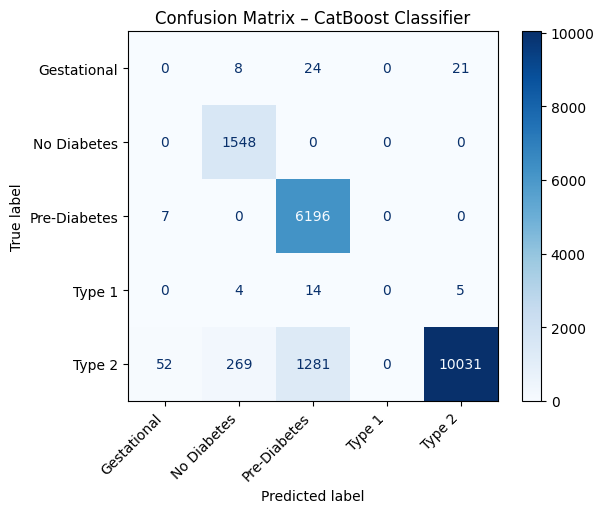

 Evaluasi Model: Random Forest Classifier
Akurasi: 0.9145

Classification Report:
              precision    recall  f1-score   support

 Gestational       0.00      0.00      0.00        53
 No Diabetes       0.85      1.00      0.92      1548
Pre-Diabetes       0.82      0.99      0.90      6203
      Type 1       0.00      0.00      0.00        23
      Type 2       0.99      0.87      0.93     11633

    accuracy                           0.91     19460
   macro avg       0.53      0.57      0.55     19460
weighted avg       0.92      0.91      0.91     19460



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 600x500 with 0 Axes>

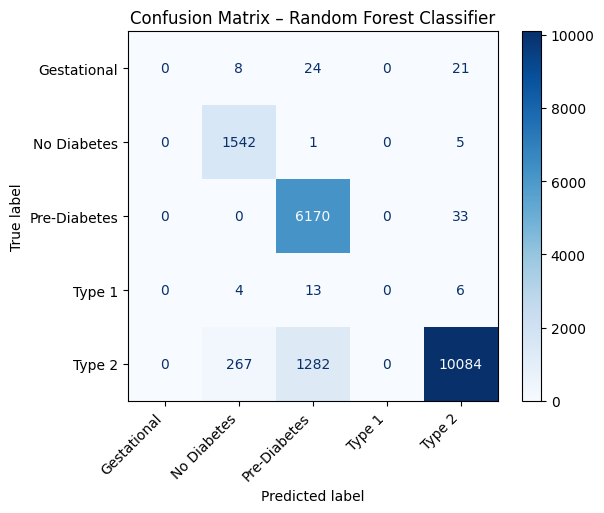

 Evaluasi Model: XGBoost Classifier
Akurasi: 0.9161

Classification Report:
              precision    recall  f1-score   support

 Gestational       0.00      0.00      0.00        53
 No Diabetes       0.85      1.00      0.92      1548
Pre-Diabetes       0.83      1.00      0.90      6203
      Type 1       0.00      0.00      0.00        23
      Type 2       1.00      0.87      0.93     11633

    accuracy                           0.92     19460
   macro avg       0.53      0.57      0.55     19460
weighted avg       0.93      0.92      0.92     19460



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 600x500 with 0 Axes>

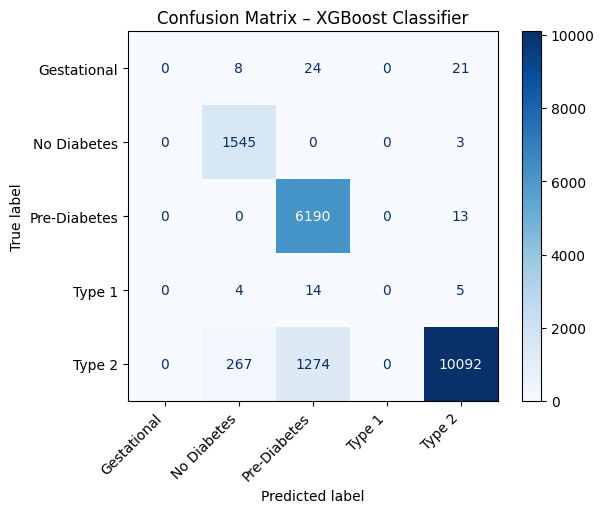


======= RINGKASAN AKURASI MODEL =======
CatBoost     : 0.9134
RandomForest : 0.9145
XGBoost      : 0.9161

 Model Final yang dipilih untuk proyek: **CatBoost (berdasarkan pertimbangan proyek)**


In [ ]:
# Bagian 4: Evaluasi, Visualisasi Confusion Matrix
# ------------------------------------------------------------------

# Fungsi bantu untuk evaluasi tiap model
def evaluate_model(model, X_test, y_test, model_name):
    print("="*70)
    print(f" Evaluasi Model: {model_name}")
    print("="*70)

    # Prediksi
    y_pred = model.predict(X_test)

    # Jika hasil prediksi berbentuk 2D (misalnya XGB), flatten
    if len(y_pred.shape) > 1:
        y_pred = y_pred.flatten()

    # Akurasi
    acc = accuracy_score(y_test, y_pred)
    print(f"Akurasi: {acc:.4f}\n")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_encoder.classes_)
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix – {model_name}")
    plt.xticks(rotation=45, ha='right')
    plt.show()

    return acc


# ----------------------------------------------------
# 1. Evaluasi Ketiga Model
# ----------------------------------------------------

acc_cat = evaluate_model(cat_model, X_test, y_test, "CatBoost Classifier")
acc_rf  = evaluate_model(rf_model, X_test, y_test, "Random Forest Classifier")
acc_xgb = evaluate_model(xgb_model, X_test, y_test, "XGBoost Classifier")

print("\n======= RINGKASAN AKURASI MODEL =======")
print(f"CatBoost     : {acc_cat:.4f}")
print(f"RandomForest : {acc_rf:.4f}")
print(f"XGBoost      : {acc_xgb:.4f}")

print("\n Model Final yang dipilih untuk proyek: **CatBoost (berdasarkan pertimbangan proyek)**")


In [ ]:
# Bagian 5: Penyimpanan Model Final
# ------------------------------------------------------------------

# Model final sesuai keputusan project → CATBOOST
final_model = cat_model

model_filename = "full_diabetes_pipeline.pkl"
encoders_filename = "target_encoders.pkl"

# Simpan pipeline model
joblib.dump(final_model, model_filename)
print(f"\nPipeline Model CatBoost disimpan sebagai: {model_filename}")

# Simpan encoder target
with open(encoders_filename, "wb") as f:
    pickle.dump(encoders, f)
print(f"Target Encoders disimpan sebagai: {encoders_filename}")

# Jika di Google Colab, lakukan download otomatis
try:
    files.download(model_filename)
    files.download(encoders_filename)
    print("\n File berhasil diunduh.")
except:
    print("\n File tersimpan di storage dan siap diunduh manual.")



Pipeline Model CatBoost disimpan sebagai: full_diabetes_pipeline.pkl
Target Encoders disimpan sebagai: target_encoders.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 File berhasil diunduh.
